<a href="https://colab.research.google.com/github/amar-naik/EVA/blob/master/S5/S5_step4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

Target:

Adding Gap and dropping the last kernel

Results:

Parameters: 7944

Best Train Accuracy: 83.09

Best Test Accuracy: 98.72

Analysis:

Overfitting has increased. High variation between train/test accuracy. Since we have reduced model capacity, reduction in performance is expected. 

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


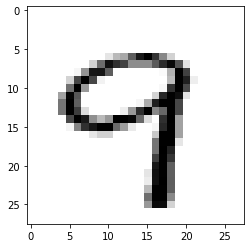

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

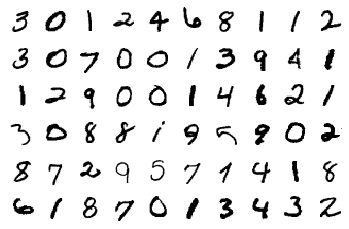

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
  
        # Input Block RF = 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),            
            nn.BatchNorm2d(12),
            nn.ReLU(), # output_size = 28 RF = 3
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),           
            nn.BatchNorm2d(14),
            nn.ReLU() , # output_size = 28 RF = 5
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),            
            nn.BatchNorm2d(16),
            nn.ReLU()  # output_size = 28 RF = 7
            )
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14 RF = 8
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),            
            nn.BatchNorm2d(14),
            nn.ReLU(),       # output_size = 12 RF = 12
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),            
            nn.BatchNorm2d(10),
            nn.ReLU(), # output_size = 10 RF = 16
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),            
            #nn.BatchNorm2d(8),
            #nn.ReLU()# output_size = 8 RF = 20 
            )   
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 4 RF = 22
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(4, 4), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1 RF = 34
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1
        self.dropout = nn.Dropout(0.25)
      

    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)
        #print(x.shape)
        x = self.pool1(x)
        #print(x.shape)
        x = self.convblock2(x)
        #print(x.shape)
        x = self.gap(x)
        x = self.dropout(x)
        #x = self.pool2(x)
        #x = self.convblock3(x)
        #print(x.shape)
        x = x.view(-1, 10)
        #print(x.shape)
        #x = x.view(x.size(0), -1)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             108
       BatchNorm2d-2           [-1, 12, 28, 28]              24
              ReLU-3           [-1, 12, 28, 28]               0
            Conv2d-4           [-1, 14, 28, 28]           1,512
       BatchNorm2d-5           [-1, 14, 28, 28]              28
              ReLU-6           [-1, 14, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]           2,016
       BatchNorm2d-8           [-1, 16, 28, 28]              32
              ReLU-9           [-1, 16, 28, 28]               0
          Dropout-10           [-1, 16, 28, 28]               0
        MaxPool2d-11           [-1, 16, 14, 14]               0
           Conv2d-12           [-1, 14, 12, 12]           2,016
      BatchNorm2d-13           [-1, 14, 12, 12]              28
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.4230293035507202 Batch_id=468 Accuracy=70.54: 100%|██████████| 469/469 [00:10<00:00, 45.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2457, Accuracy: 9337/10000 (93.37%)

EPOCH: 1


Loss=0.3517967462539673 Batch_id=468 Accuracy=81.22: 100%|██████████| 469/469 [00:10<00:00, 43.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1195, Accuracy: 9695/10000 (96.95%)

EPOCH: 2


Loss=0.4331267774105072 Batch_id=468 Accuracy=81.90: 100%|██████████| 469/469 [00:10<00:00, 43.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1179, Accuracy: 9660/10000 (96.60%)

EPOCH: 3


Loss=0.43488869071006775 Batch_id=468 Accuracy=82.40: 100%|██████████| 469/469 [00:10<00:00, 44.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9831/10000 (98.31%)

EPOCH: 4


Loss=0.3302958905696869 Batch_id=468 Accuracy=82.62: 100%|██████████| 469/469 [00:10<00:00, 44.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9804/10000 (98.04%)

EPOCH: 5


Loss=0.38166964054107666 Batch_id=468 Accuracy=82.62: 100%|██████████| 469/469 [00:10<00:00, 45.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1204, Accuracy: 9635/10000 (96.35%)

EPOCH: 6


Loss=0.36904677748680115 Batch_id=468 Accuracy=82.98: 100%|██████████| 469/469 [00:10<00:00, 42.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9875/10000 (98.75%)

EPOCH: 7


Loss=0.35408005118370056 Batch_id=468 Accuracy=82.90: 100%|██████████| 469/469 [00:10<00:00, 42.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9837/10000 (98.37%)

EPOCH: 8


Loss=0.3455330431461334 Batch_id=468 Accuracy=83.16: 100%|██████████| 469/469 [00:10<00:00, 43.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Accuracy: 9827/10000 (98.27%)

EPOCH: 9


Loss=0.3309333324432373 Batch_id=468 Accuracy=83.16: 100%|██████████| 469/469 [00:10<00:00, 44.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9863/10000 (98.63%)

EPOCH: 10


Loss=0.2851879298686981 Batch_id=468 Accuracy=83.09: 100%|██████████| 469/469 [00:10<00:00, 44.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0785, Accuracy: 9754/10000 (97.54%)

EPOCH: 11


Loss=0.32464590668678284 Batch_id=468 Accuracy=83.11: 100%|██████████| 469/469 [00:11<00:00, 42.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9857/10000 (98.57%)

EPOCH: 12


Loss=0.3276677429676056 Batch_id=468 Accuracy=83.06: 100%|██████████| 469/469 [00:10<00:00, 44.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9865/10000 (98.65%)

EPOCH: 13


Loss=0.31687232851982117 Batch_id=468 Accuracy=83.51: 100%|██████████| 469/469 [00:10<00:00, 49.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9872/10000 (98.72%)

EPOCH: 14


Loss=0.231614351272583 Batch_id=468 Accuracy=83.39: 100%|██████████| 469/469 [00:10<00:00, 44.49it/s]



Test set: Average loss: 0.0563, Accuracy: 9824/10000 (98.24%)



Text(0.5, 1.0, 'Test Accuracy')

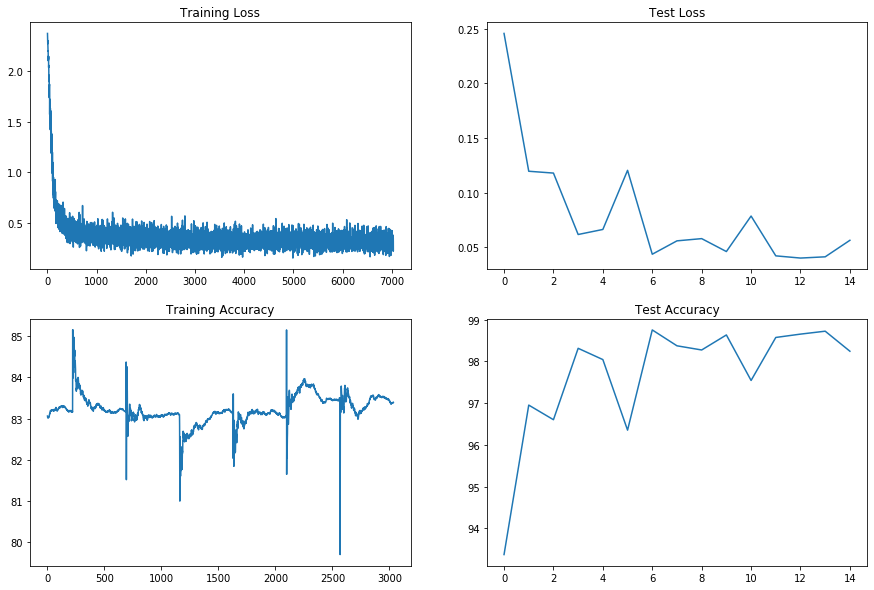

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")